In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from datetime import datetime as dt
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt


confirmed_cases = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
confirmed_deaths = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
confirmed_recovered = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')

In [2]:
confirmed_recovered

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20
0,NaN,Afghanistan,33.000000,65.000000,0,0,0,0,0,0,...,99,112,131,135,150,166,179,188,188,207
1,NaN,Albania,41.153300,20.168300,0,0,0,0,0,0,...,283,302,314,327,345,356,385,394,403,410
2,NaN,Algeria,28.033900,1.659600,0,0,0,0,0,0,...,846,894,1047,1099,1152,1204,1355,1408,1479,1508
3,NaN,Andorra,42.506300,1.521800,0,0,0,0,0,0,...,191,205,235,248,282,309,333,344,344,344
4,NaN,Angola,-11.202700,17.873900,0,0,0,0,0,0,...,5,6,6,6,6,6,6,6,6,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,Saint Pierre and Miquelon,France,46.885200,-56.315900,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
246,NaN,South Sudan,6.877000,31.307000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
247,NaN,Western Sahara,24.215500,-12.885800,0,0,0,0,0,0,...,0,0,0,0,0,0,5,5,5,5
248,NaN,Sao Tome and Principe,0.186360,6.613081,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
confirmed_cases['Province/State']

0                            NaN
1                            NaN
2                            NaN
3                            NaN
4                            NaN
                 ...            
259    Saint Pierre and Miquelon
260                          NaN
261                          NaN
262                          NaN
263                          NaN
Name: Province/State, Length: 264, dtype: object

In [4]:
class MLP():
    def __init__(self):
        pass
    def NormalizeData(self,df):
        self.scaler = MinMaxScaler(feature_range=(-1, 1))
        self.normalized = self.scaler.fit_transform(df)
        print(self.normalized)
        return self.normalized,self.scaler
        
    def Denormalize(self,dfNormalized):
        pass
    
    
    def PrepareData(self,timesteps):
        i = 0
        self.X = []
        self.Y = []
        while i in range(len(self.normalized - timesteps)):
            input_index = i + timesteps
            label_index = input_index + 1
            if(label_index < len(self.normalized)):
                self.X.append(self.normalized[i:input_index,0:1])
                self.Y.append(self.normalized[input_index:label_index,0:1])
            i+=1
        self.X = np.array(self.X)
        self.Y = np.array(self.Y)
        print(self.X)
        X = self.X
        print(self.Y)
        Y=self.Y
    
    '''
    def Prepare_Data(self,dataset):
        x = dataset.drop(columns=['Total_Deaths'])
        self.X = x.to_numpy()
        y = dataset['Total_Deaths']
        self.Y = y.to_numpy()
        self.Y = self.Y.astype(float)
    '''
    def Build(self,janela,nmr_parametros):
        self.model = keras.Sequential()
        self.model.add(keras.layers.LSTM(216, input_shape=(janela, nmr_parametros), return_sequences=True))
        self.model.add(keras.layers.LSTM(128, return_sequences=True))
        self.model.add(keras.layers.LSTM(64, return_sequences=False))
        self.model.add(keras.layers.Dense(16, activation="relu", kernel_initializer="uniform"))
        self.model.add(keras.layers.Dense(1, activation="linear"))
                       
    def RMSE(self,y_true,y_pred):
        return keras.backend.sqrt(keras.backend.mean(keras.backend.square(y_pred - y_true)))

    def Fit(self):
        self.model.compile(loss=self.RMSE,optimizer=keras.optimizers.Adam(),metrics=['mae',self.RMSE])
        self.history = self.model.fit(x=self.X,y=self.Y,epochs=150,shuffle=False,verbose=True)
    def Predict(self,data):
        result = self.model.predict(data,verbose=True)
        return result

In [5]:
class Data():
    def __init__(self):
        pass
    def PreparaData(self,confirmed,deaths,recovered):
        confirmed = confirmed.drop(columns=['Province/State','Country/Region','Lat','Long'])
        deaths = deaths.drop(columns=['Province/State','Country/Region','Lat','Long'])
        recovered = recovered.drop(columns=['Province/State','Country/Region','Lat','Long'])
        timesteps = []
        total_infetados = []
        total_Days = []
        total_Deaths = []
        total_Recovered = []
        self.new_dataset = pd.DataFrame()
        Ground_Zero = dt.strptime('12/31/19','%m/%d/%y')
        for cols in confirmed.columns:
            timesteps.append(cols)
            total_infetados.append(confirmed[cols].sum())
            current_date = dt.strptime(cols,'%m/%d/%y')
            days_Gone = current_date - Ground_Zero
            total_Days.append(int(days_Gone.days))
        for cols in deaths.columns:
            total_Deaths.append(deaths[cols].sum())
        for cols in recovered.columns:
            total_Recovered.append(recovered[cols].sum())
        self.new_dataset['Total_Cases'] = total_infetados
        self.new_dataset['Total_Recovered'] = total_Recovered
        self.new_dataset['Total_Deaths'] = total_Deaths
        self.new_dataset['Days_Gone'] = total_Days
        pd.DataFrame.to_csv(self.new_dataset,'Dados/new_dataset.csv')

In [6]:
data = Data()
data.PreparaData(confirmed_cases,confirmed_deaths,confirmed_recovered)
print(data.new_dataset)

    Total_Cases  Total_Recovered  Total_Deaths  Days_Gone
0           555               28            17         22
1           654               30            18         23
2           941               36            26         24
3          1434               39            42         25
4          2118               52            56         26
..          ...              ...           ...        ...
91      2623049           710502        183064        113
92      2707728           739409        190857        114
93      2809499           790081        197004        115
94      2896744           817838        202844        116
95      2971475           865733        206542        117

[96 rows x 4 columns]


In [7]:
model = MLP()
model.Build(7,1)
data_norm,scaler=model.NormalizeData(data.new_dataset)
model.PrepareData(7)
print(scaler)

[[-1.         -1.         -1.         -1.        ]
 [-0.99993335 -0.99999538 -0.99999032 -0.97894737]
 [-0.99974015 -0.99998152 -0.99991284 -0.95789474]
 [-0.99940826 -0.99997459 -0.9997579  -0.93684211]
 [-0.9989478  -0.99994455 -0.99962232 -0.91578947]
 [-0.99840319 -0.99992376 -0.99937054 -0.89473684]
 [-0.99661856 -0.99981749 -0.99889602 -0.87368421]
 [-0.99622272 -0.99977359 -0.99887665 -0.85263158]
 [-0.99483056 -0.99973432 -0.99850866 -0.83157895]
 [-0.99369084 -0.99955181 -0.99810192 -0.81052632]
 [-0.99226973 -0.99940857 -0.99765646 -0.78947368]
 [-0.98907275 -0.99897425 -0.996659   -0.76842105]
 [-0.98698989 -0.9986254  -0.99603922 -0.74736842]
 [-0.98428971 -0.99809635 -0.99540007 -0.72631579]
 [-0.98176996 -0.99746796 -0.99470282 -0.70526316]
 [-0.97964334 -0.99662934 -0.99402494 -0.68421053]
 [-0.97722187 -0.99541876 -0.99320179 -0.66315789]
 [-0.97538473 -0.99402106 -0.99235928 -0.64210526]
 [-0.97334496 -0.99257022 -0.99139087 -0.62105263]
 [-0.97158658 -0.99094842 -0.99

In [8]:
model.Fit()

Train on 88 samples
Epoch 1/150
88/88 [==============================] - 6s 63ms/sample - loss: 0.7696 - mae: 0.7387 - RMSE: 0.7461
Epoch 2/150
88/88 [==============================] - 0s 693us/sample - loss: 0.7184 - mae: 0.6871 - RMSE: 0.6987
Epoch 3/150
88/88 [==============================] - 0s 693us/sample - loss: 0.6206 - mae: 0.5900 - RMSE: 0.6086
Epoch 4/150
88/88 [==============================] - 0s 693us/sample - loss: 0.4119 - mae: 0.3962 - RMSE: 0.4202
Epoch 5/150
88/88 [==============================] - 0s 716us/sample - loss: 0.2371 - mae: 0.2224 - RMSE: 0.2613
Epoch 6/150
88/88 [==============================] - 0s 705us/sample - loss: 0.2045 - mae: 0.1866 - RMSE: 0.2279
Epoch 7/150
88/88 [==============================] - 0s 716us/sample - loss: 0.2050 - mae: 0.1904 - RMSE: 0.2255
Epoch 8/150
88/88 [==============================] - 0s 727us/sample - loss: 0.1904 - mae: 0.1711 - RMSE: 0.2092
Epoch 9/150
88/88 [==============================] - 0s 693us/sample - loss: 

88/88 [==============================] - 0s 864us/sample - loss: 0.1123 - mae: 0.1074 - RMSE: 0.1052
Epoch 73/150
88/88 [==============================] - 0s 886us/sample - loss: 0.0665 - mae: 0.0634 - RMSE: 0.0649
Epoch 74/150
88/88 [==============================] - 0s 875us/sample - loss: 0.1035 - mae: 0.1000 - RMSE: 0.0982
Epoch 75/150
88/88 [==============================] - 0s 761us/sample - loss: 0.0454 - mae: 0.0405 - RMSE: 0.0460
Epoch 76/150
88/88 [==============================] - 0s 693us/sample - loss: 0.0973 - mae: 0.0924 - RMSE: 0.0905
Epoch 77/150
88/88 [==============================] - 0s 807us/sample - loss: 0.0670 - mae: 0.0603 - RMSE: 0.0684
Epoch 78/150
88/88 [==============================] - 0s 807us/sample - loss: 0.0736 - mae: 0.0696 - RMSE: 0.0710
Epoch 79/150
88/88 [==============================] - 0s 807us/sample - loss: 0.0450 - mae: 0.0402 - RMSE: 0.0465
Epoch 80/150
88/88 [==============================] - 0s 818us/sample - loss: 0.0462 - mae: 0.0396 - 

88/88 [==============================] - 0s 818us/sample - loss: 0.0313 - mae: 0.0268 - RMSE: 0.0303
Epoch 144/150
88/88 [==============================] - 0s 830us/sample - loss: 0.0402 - mae: 0.0364 - RMSE: 0.0387
Epoch 145/150
88/88 [==============================] - 0s 761us/sample - loss: 0.0305 - mae: 0.0259 - RMSE: 0.0295
Epoch 146/150
88/88 [==============================] - 0s 705us/sample - loss: 0.0404 - mae: 0.0366 - RMSE: 0.0388
Epoch 147/150
88/88 [==============================] - 0s 739us/sample - loss: 0.0308 - mae: 0.0262 - RMSE: 0.0298
Epoch 148/150
88/88 [==============================] - 0s 727us/sample - loss: 0.0400 - mae: 0.0362 - RMSE: 0.0385
Epoch 149/150
88/88 [==============================] - 0s 727us/sample - loss: 0.0305 - mae: 0.0260 - RMSE: 0.0296
Epoch 150/150
88/88 [==============================] - 0s 705us/sample - loss: 0.0400 - mae: 0.0362 - RMSE: 0.0385


In [9]:
def forecast(model,df,timesteps,multisteps,data_norm,scaler):
    data_norm=pd.DataFrame(data_norm)
    input_seq=data_norm[-timesteps:].values
    inp=input_seq[:,0]
    
    
    predictions=list()
    
    inp = np.array(inp).astype('float32')
    print(inp)
    for step in range(1, multisteps+1):
        
        inp=inp.reshape(1,timesteps,1)
        
        yhat=model.Predict(inp)
        
        Denormalized = np.ndarray((1,4))
        Denormalized[0][0] = yhat
        Denormalized[0][1] = -1
        Denormalized[0][2] = -1
        Denormalized[0][3] = -1
        value = model.scaler.inverse_transform(Denormalized)
        print(value)
        predictions.append(value[0][0])
        #predictions.append(yhat[0][0])
        inp=np.append(inp[0],yhat)
        inp=inp[-timesteps:]
        #print(inp)
        
    return predictions
print(scaler)
prediction = forecast(model,data.new_dataset,7,10,data_norm,scaler)
# Denormalized = np.ndarray((1,4))
# Denormalized[0][0] = -1
# Denormalized[0][1] = -1
# Denormalized[0][2] = prediction
# Denormalized[0][3] = -1
# Denormalized1 = np.transpose(Denormalized)
# value = model.scaler.inverse_transform(Denormalized)
# print(value)
print(prediction)

MinMaxScaler(copy=True, feature_range=(-1, 1))
[0.66325045 0.7149812  0.7654424  0.8224476  0.890959   0.94969165
 1.        ]
1/1 [==============================] - 1s 1s/sample
[[2.98736161e+06 2.80000000e+01 1.70000000e+01 2.20000000e+01]]
1/1 [==============================] - 0s 5ms/sample
[[3.05032369e+06 2.80000000e+01 1.70000000e+01 2.20000000e+01]]
1/1 [==============================] - 0s 4ms/sample
[[3.11087464e+06 2.80000000e+01 1.70000000e+01 2.20000000e+01]]
1/1 [==============================] - 0s 5ms/sample
[[3.16890786e+06 2.80000000e+01 1.70000000e+01 2.20000000e+01]]
1/1 [==============================] - 0s 4ms/sample
[[3.22161556e+06 2.80000000e+01 1.70000000e+01 2.20000000e+01]]
1/1 [==============================] - 0s 5ms/sample
[[3.26432139e+06 2.80000000e+01 1.70000000e+01 2.20000000e+01]]
1/1 [==============================] - 0s 5ms/sample
[[3.29917829e+06 2.80000000e+01 1.70000000e+01 2.20000000e+01]]
1/1 [==============================] - 0s 5ms/sample
[[

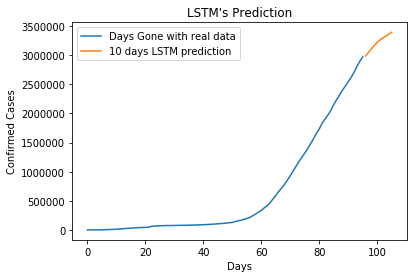

In [10]:
plt.plot(np.arange(len(data.new_dataset)),(data.new_dataset['Total_Cases']), label='Days Gone with real data')
plt.plot(np.arange(len(data.new_dataset),len(data.new_dataset) + len(prediction)),(prediction), label='10 days LSTM prediction')
plt.title("LSTM's Prediction")
plt.xlabel('Days')
plt.ylabel('Confirmed Cases')
#plt.axis([1000,1250,10,25])
plt.legend()
plt.show();